In [1]:
%matplotlib inline
import torch
from torch import nn
from torch.nn import functional as F
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path
import utils
import torchvision
from torchvision.io import image
from torchvision.transforms.functional import to_pil_image
import pandas as pd
import time
import numpy as np
import collections
import re
import random

In [2]:
tokens = utils.tokenize(utils.read_ebook_txt(utils.sanguo_txt_path), token='word')
# 所有文本行拼接到一起
corpus = [token for line in tokens for token in line]
vocab = utils.Vocab(corpus)
vocab.token_freqs[:10]

[('the', 35403),
 ('and', 23708),
 ('to', 19311),
 ('of', 16145),
 ('a', 9567),
 ('he', 9073),
 ('his', 8911),
 ('in', 7110),
 ('was', 6718),
 ('you', 4999)]

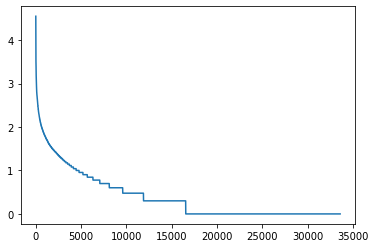

In [3]:
# 词频以一种明确的方式迅速衰减
freqs = [freq for token, freq in vocab.token_freqs]
plt.plot(np.log10(freqs))

In [4]:
# 二元语法的频率

bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = utils.Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 4265),
 (('to', 'the'), 2385),
 (('in', 'the'), 2117),
 (('and', 'the'), 1628),
 (('cao', 'cao'), 1424),
 (('on', 'the'), 1129),
 (('liu', 'bei'), 1067),
 (('at', 'the'), 949),
 (('of', 'his'), 884),
 (('he', 'was'), 823)]

In [5]:
# 三元语法的频率

trigram_tokens = [triple for triple in zip(corpus[:-2], corpus[1:-1], corpus[2:])]
trigram_vocab = utils.Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('out', 'of', 'the'), 201),
 (('the', 'ruler', 'of'), 186),
 (('as', 'soon', 'as'), 175),
 (('one', 'of', 'the'), 170),
 (('the', 'army', 'of'), 132),
 (('the', 'prime', 'minister'), 124),
 (('said', 'cao', 'cao.'), 121),
 (('and', 'i', 'will'), 115),
 (('the', 'soldiers', 'of'), 114),
 (('the', 'troops', 'of'), 105)]

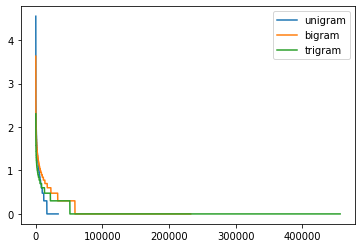

In [6]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]

plt.plot(np.log10(freqs))
plt.plot(np.log10(bigram_freqs))
plt.plot(np.log10(trigram_freqs))
plt.legend(['unigram', 'bigram', 'trigram'])

In [7]:
# 随机采样

def seq_data_iter_random(corpus, batch_size, num_steps):
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    corpus = corpus[random.randint(0, num_steps - 1):]
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)

    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size
    for i in range(0, batch_size * num_batches, batch_size):
        # 在这里，initial_indices包含子序列的随机起始索引
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        X = [data(j) for j in initial_indices_per_batch]
        Y = [data(j + 1) for j in initial_indices_per_batch]
        yield torch.tensor(X), torch.tensor(Y)

In [8]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[10, 11, 12, 13, 14],
        [25, 26, 27, 28, 29]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [26, 27, 28, 29, 30]])
X:  tensor([[20, 21, 22, 23, 24],
        [ 0,  1,  2,  3,  4]]) 
Y: tensor([[21, 22, 23, 24, 25],
        [ 1,  2,  3,  4,  5]])
X:  tensor([[15, 16, 17, 18, 19],
        [ 5,  6,  7,  8,  9]]) 
Y: tensor([[16, 17, 18, 19, 20],
        [ 6,  7,  8,  9, 10]])


In [9]:
# 顺序分区

def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

In [10]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 5,  6,  7,  8,  9],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[ 6,  7,  8,  9, 10],
        [20, 21, 22, 23, 24]])
X:  tensor([[10, 11, 12, 13, 14],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [25, 26, 27, 28, 29]])


In [11]:
class SeqDataLoader:  
    """加载序列数据的迭代器"""
    def __init__(self, txt_Path: Path, batch_size, num_steps, use_random_iter, max_tokens):
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = utils.load_corpus_txt(txt_Path, max_tokens=max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

In [12]:
def load_data_txt(txt_path: Path, batch_size, num_steps, use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(txt_path, batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab